# Description

The notebook simulates the performance of a "pegged-at-mid" trading algorithm.

- Load the 1sec bid/ask data
- Conduct a sanity check
- Calculate the midpoint limit buy/sell prices
- Aggregate to 5T and check the success of trades in historical data

```
dataset_signature=periodic.airflow.downloaded_EOD.parquet.bid_ask.futures.v3.cryptochassis.binance.v1_0_0
```

In [1]:
%load_ext autoreload
%autoreload 2
import logging

import pandas as pd

import core.finance as cofinanc
import core.statistics as costatis
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import research_amp.cc.algotrading as ramccalg

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-4c899256-c557-4cce-9722-e06b42610d67.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTaks4775_Move_Out_all_the_notebook_tests_from_dir2'
  hash='3f9eb3436'
  # Last commits:
    *   3f9eb3436 DanilYachmenev Merge branch 'master' into CmTaks4775_Move_Out_all_the_notebook_tests_from_dir2 (22 minutes ago) Thu Jul 13 11:48:30 2023  (HEAD -> CmTaks4775_Move_Out_all_the_notebook_tests_from_dir2, origin/CmTaks4775_Move_Out_all_the_notebook_tests_from_dir2)
    |\  
    | * e53992630 Nina Lee Cm task4487 change pr

# Load CryptoChassis data.

## Initialize MarketData for `read_data` node

In [3]:
# Load the default config.
config = ramccalg.get_default_config()

In [4]:
# Load the historical IM client.
client = ramccalg.get_bid_ask_ImClient(config)
# Load the asset ids of the given universe.
asset_ids = ramccalg.get_universe(config, full_symbols=["binance::ADA_USDT"])
# Set up MarketData for
market_data = ramccalg.get_market_data(config)

## Initialize DAG

In [5]:
start_ts = config.get_and_mark_as_used(("market_data_config", "start_ts"))
end_ts = config.get_and_mark_as_used(("market_data_config", "end_ts"))
intervals = [(start_ts, end_ts)]


def _run_dag_node(dag):
    dag_runner = dtfcore.FitPredictDagRunner(dag)
    dag_runner.set_fit_intervals(intervals)
    fit_result_bundle = dag_runner.fit()
    df = fit_result_bundle.result_df
    return df

In [6]:
# Create an empty DAG.
dag = dtfcore.DAG(mode="strict")
dtfcore.draw(dag)

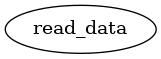

In [7]:
stage = "read_data"
ts_col_name = "end_ts"
multiindex_output = True
col_names_to_remove = []
node = dtfsys.HistoricalDataSource(
    stage,
    market_data,
    ts_col_name,
    multiindex_output,
    col_names_to_remove=col_names_to_remove,
)
dag.insert_at_head(node)
dtfcore.draw(dag)

## Read data

In [8]:
df_original = _run_dag_node(dag)
df_original.shape
df_original.head(5)

run_leq_node:   0%|          | 0/1 [00:00<?, ?it/s]

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
,3303714233,3303714233,3303714233,3303714233,3303714233,3303714233,3303714233
end_ts,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00


In [9]:
# Drop multiindex in single-asset dataframes for human readability.
if len(asset_ids) < 2:
    df_flat = df_original.droplevel(1, axis=1)
else:
    df_flat = df_original.copy()

In [10]:
df_flat.head()

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00


## Sanity check

A quick sanity-check for the following:
- What percentage of 1 sec bars are missing?
- How often is bid_size = 0, ask_size = 0, volume=0?
- How often is bid !< ask?


In [11]:
# Check for missing data.
df_flat.isna().sum()

ask_price              0
ask_size               0
bid_price              0
bid_size               0
full_symbol            0
knowledge_timestamp    0
start_ts               0
dtype: int64

In [12]:
# Check for zeroes.
(df_flat == 0).astype(int).sum(axis=1).sum()

0

In [13]:
# Check bid price !< ask price.
(df_flat["bid_price"] >= df_flat["ask_price"]).any().any()

False

In [14]:
df_flat.head()

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00


In [15]:
# Check the gaps inside the time series.
index_as_series = df_flat.index.to_series()
freq = "S"
gaps_in_seconds = hpandas.find_gaps_in_time_series(
    index_as_series, start_ts, end_ts, freq
)
gaps_in_seconds = gaps_in_seconds.to_series()

In [16]:
gaps_percent = len(gaps_in_seconds) / (len(df_flat) + len(gaps_in_seconds)) * 100
average_gap = gaps_in_seconds.diff().mean()
print(
    f"Overall {len(gaps_in_seconds)} gaps were found, \
for {gaps_percent}%% of all seconds in the given period, for an average frequency of {average_gap}"
)

Overall 575 gaps were found, for 0.6655015566949456%% of all seconds in the given period, for an average frequency of 0 days 00:02:30.318815331


<AxesSubplot: >

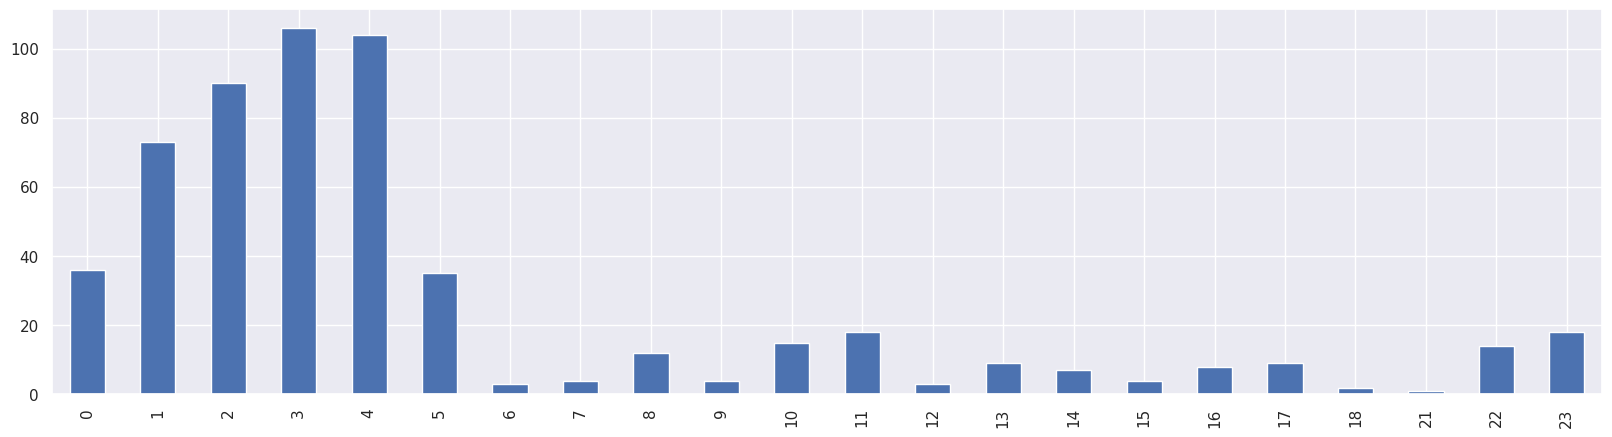

In [17]:
# Display gaps distribution by hour.
gaps_in_seconds.groupby(gaps_in_seconds.dt.hour).count().plot(kind="bar")

### Commentary

- No NaNs or zeroes were found with a simple general check, there is no need for an in-depth look.
- 575 gaps were found, that mostly concentrate between 0am and 5am.

## Augment data with new features

In [18]:
# Append `mid` data.
# # (bid + ask) / 2.
bid_col = "bid_price"
ask_col = "ask_price"
bid_volume_col = "bid_size"
ask_volume_col = "ask_size"
requested_cols = ["mid", "ask_value", "bid_value"]
join_output_with_input = True
df_mid = cofinanc.process_bid_ask(
    df_flat,
    bid_col,
    ask_col,
    bid_volume_col,
    ask_volume_col,
    requested_cols=requested_cols,
    join_output_with_input=join_output_with_input,
)
df_mid.head(10)

,ask_value,bid_value,mid,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,,,,
2022-12-13 19:00:00-05:00,53805.9582,25894.3240,0.31405,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,53805.9582,25807.0320,0.31405,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,53798.1057,25807.0320,0.31405,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,53803.4454,25807.0320,0.31405,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,12683.0880,26973.1131,0.31395,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00
2022-12-13 19:00:07-05:00,28999.7840,39062.6577,0.31395,0.3140,92356.0,0.3139,124443.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:07-05:00
2022-12-13 19:00:08-05:00,104967.0600,36749.5286,0.31395,0.3140,334290.0,0.3139,117074.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:08-05:00
2022-12-13 19:00:09-05:00,97679.1200,59725.1252,0.31395,0.3140,311080.0,0.3139,190268.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:09-05:00
2022-12-13 19:00:10-05:00,98167.3900,59648.5336,0.31395,0.3140,312635.0,0.3139,190024.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:10-05:00


In [19]:
print(df_mid.shape)
print(df_mid.index.min())
print(df_mid.index.max())

(85826, 10)
2022-12-13 19:00:00-05:00
2022-12-14 19:00:00-05:00


In [20]:
df_features = df_mid.copy()

<AxesSubplot: xlabel='end_ts'>

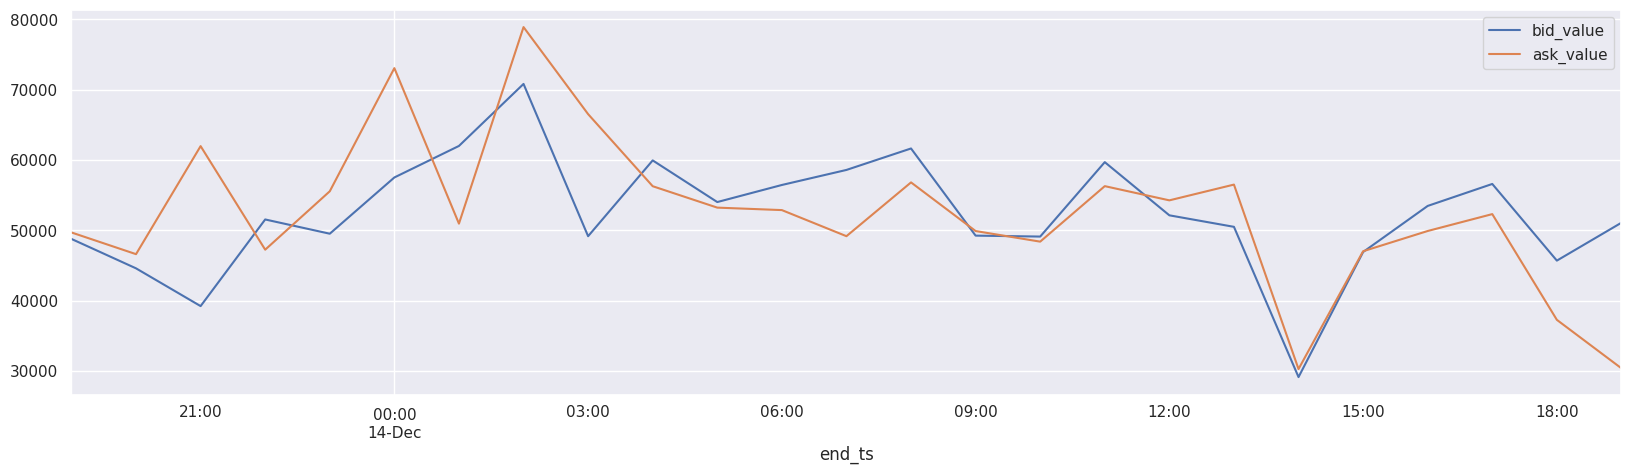

In [21]:
# Take the mean top-of-book value per hour (rather than the sum, since these are not transactions).
# Typical top-of-book value is on the order of $50k.
df_features[["bid_value", "ask_value"]].resample("1H").mean().plot()

In [22]:
mid_col_name = "mid"
debug_mode = True
resample_freq = "1T"
abs_spread = 0.0001
df_limit_order_prices = ramccalg.add_limit_order_prices(
    df_features, mid_col_name, debug_mode, abs_spread=abs_spread
)

### Check missing data indices

In [23]:
print(df_features.shape)

(85826, 10)


In [24]:
print(df_limit_order_prices.shape)

(85830, 14)


In [25]:
diff = df_limit_order_prices.index.difference(df_features.index)

In [26]:
df_limit_order_prices.loc[diff]

,ask_value,bid_value,mid,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts,limit_buy_price,limit_sell_price,is_buy,is_sell
end_ts,,,,,,,,,,,,,,
2022-12-13 20:35:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.314262,0.314462,False,False
2022-12-13 21:43:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.313338,0.313538,False,False
2022-12-13 22:26:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.313350,0.313550,False,False
2022-12-14 06:57:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.310093,0.310293,False,False


In [27]:
df_flat.loc[
    pd.Timestamp("2022-12-13 22:25:59-05:00") : pd.Timestamp(
        "2022-12-13 22:27:00-05:00"
    )
]

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,
2022-12-13 22:25:59-05:00,0.3135,46307.0,0.3134,145117.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:24:59-05:00
2022-12-13 22:26:01-05:00,0.3135,92553.0,0.3134,145710.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:01-05:00
2022-12-13 22:26:02-05:00,0.3135,93729.0,0.3134,133476.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:02-05:00
2022-12-13 22:26:03-05:00,0.3135,93729.0,0.3134,135498.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:03-05:00
2022-12-13 22:26:04-05:00,0.3135,93729.0,0.3134,133628.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:04-05:00
2022-12-13 22:26:05-05:00,0.3135,112917.0,0.3134,131201.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:05-05:00
2022-12-13 22:26:06-05:00,0.3135,93747.0,0.3134,126925.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:06-05:00
2022-12-13 22:26:07-05:00,0.3135,118692.0,0.3134,125015.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:07-05:00
2022-12-13 22:26:08-05:00,0.3135,117934.0,0.3134,125068.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 22:25:08-05:00


#### Commentary

As we have seen during the sanity check above, missing data can congregate around certain time points.

For the 4 missing minutes were minutes where the initial second was missing, and then added in the function due to resampling.

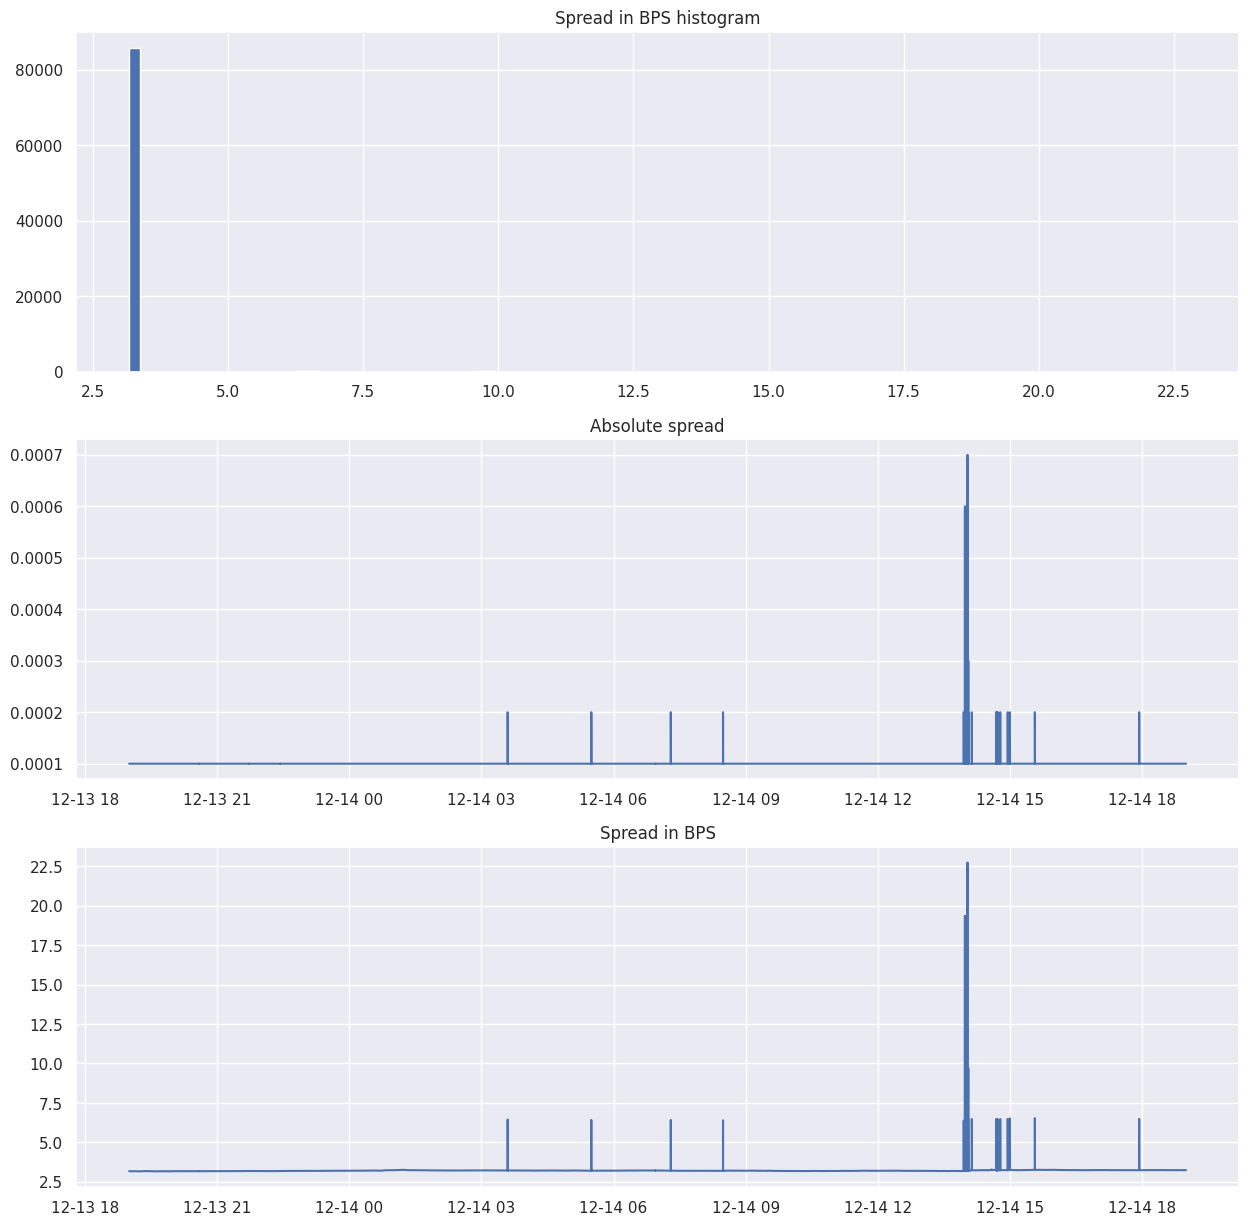

In [28]:
ramccalg.perform_spread_analysis(
    df_limit_order_prices, "ask_price", "bid_price", "mid"
)

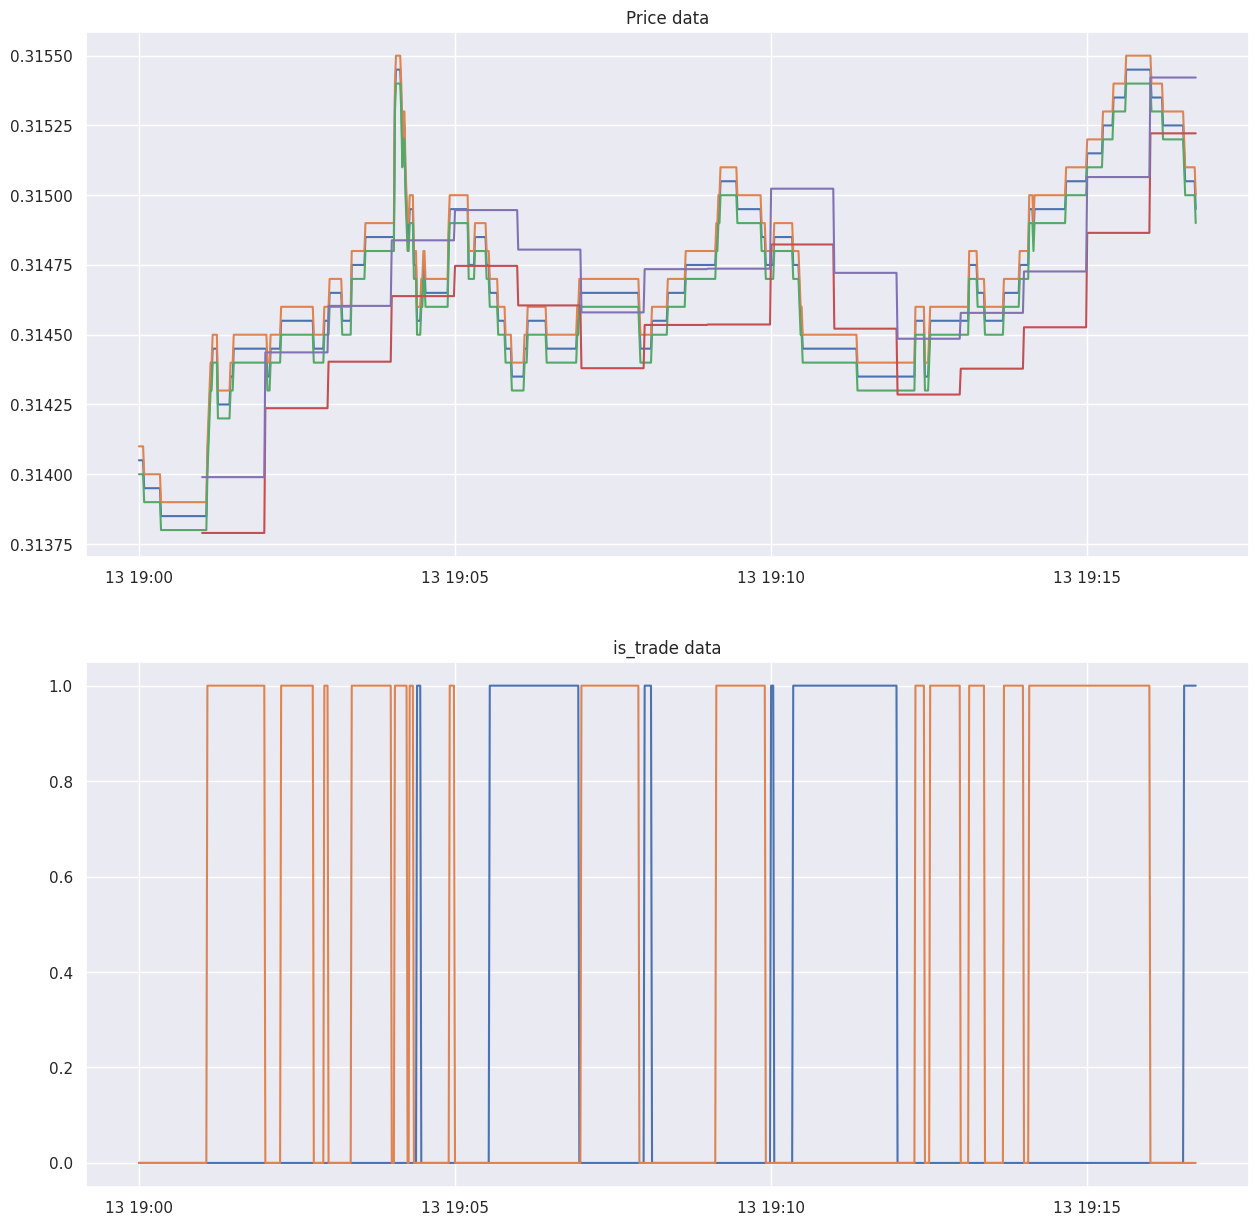

In [29]:
ramccalg.plot_limit_orders(df_limit_order_prices)

## Resample to T_reprice

In [30]:
report_stats = True
reprice_df = ramccalg.compute_repricing_df(df_limit_order_prices, report_stats)

INFO  buy percentage at repricing freq: 11646 / 85830 = 13.57%
INFO  sell percentage at repricing freq: 11661 / 85830 = 13.59%
INFO  exec_buy_price=0 =74184 / 85830 = 86.43%
INFO  exec_sell_price=0 =74169 / 85830 = 86.41%


In [31]:
reprice_df.shape

(85830, 16)

In [32]:
reprice_df.head(5)

,ask_value,bid_value,mid,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts,limit_buy_price,limit_sell_price,is_buy,is_sell,exec_buy_price,exec_sell_price
end_ts,,,,,,,,,,,,,,,,
2022-12-13 19:00:00-05:00,53805.9582,25894.3240,0.31405,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00,NaN,NaN,False,False,NaN,NaN
2022-12-13 19:00:01-05:00,53805.9582,25807.0320,0.31405,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00,NaN,NaN,False,False,NaN,NaN
2022-12-13 19:00:03-05:00,53798.1057,25807.0320,0.31405,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00,NaN,NaN,False,False,NaN,NaN
2022-12-13 19:00:04-05:00,53803.4454,25807.0320,0.31405,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00,NaN,NaN,False,False,NaN,NaN
2022-12-13 19:00:05-05:00,12683.0880,26973.1131,0.31395,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00,NaN,NaN,False,False,NaN,NaN


## Resample to T_exec

In [33]:
exec_df = ramccalg.compute_execution_df(reprice_df, report_stats=True)
exec_df.head(5)

INFO  exec_is_buy=168 / 289 = 58.13%
INFO  million USD per 5T=2.4678427398577854
INFO  exec_is_sell=180 / 289 = 62.28%
INFO  million USD per 5T=2.263855483338062


,exec_buy_num,exec_buy_price,exec_is_buy,exec_buy_volume,exec_sell_num,exec_sell_price,exec_is_sell,exec_sell_volume,mid
end_ts,,,,,,,,,
2022-12-13 19:00:00-05:00,4,0.314600,True,3.080028e+05,149,0.314590,True,1.057715e+07,0.31405
2022-12-13 19:05:00-05:00,92,0.314534,True,3.948841e+06,102,0.314748,True,4.196600e+06,0.31495
2022-12-13 19:10:00-05:00,101,0.314493,True,1.121826e+07,127,0.314724,True,9.520203e+06,0.31475
2022-12-13 19:15:00-05:00,200,0.314700,True,1.440506e+07,60,0.315272,True,3.995128e+06,0.31515
2022-12-13 19:20:00-05:00,70,0.314094,True,4.721376e+06,21,0.314000,True,1.578146e+06,0.31435


## Compare to benchmark price.

In [34]:
def compute_benchmark_stats(df):
    df["twap_mid_price"] = df["mid"].resample("5T").mean()
    df[["twap_mid_price", "exec_sell_price", "exec_buy_price"]].head(1000).plot()
    return df

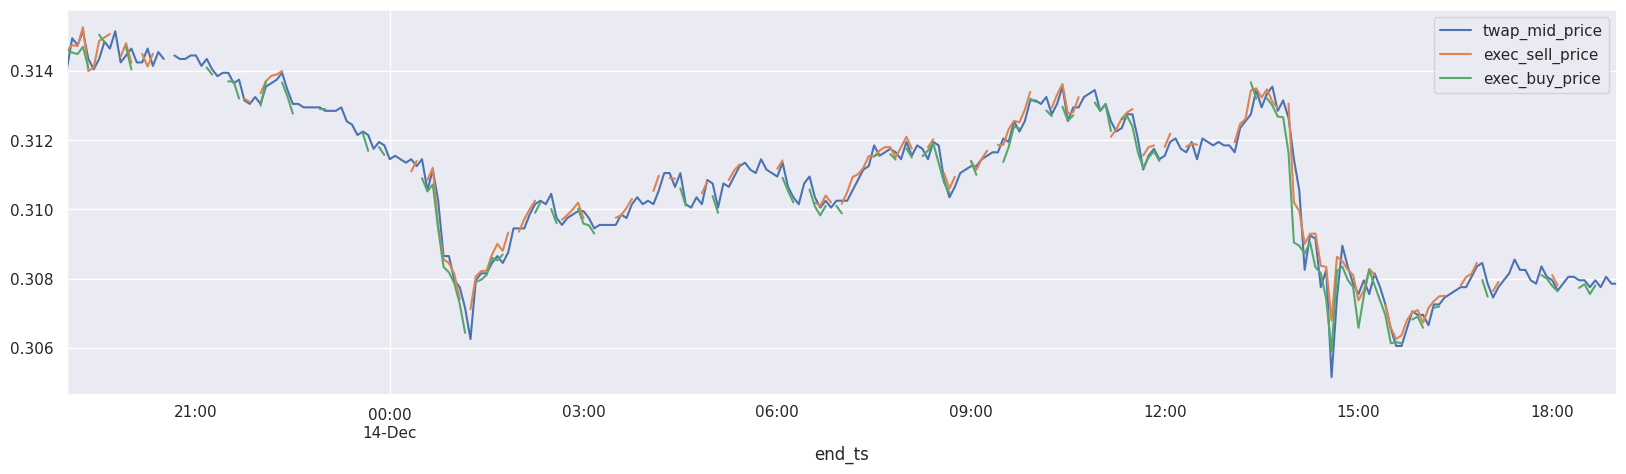

In [35]:
benchmark_df = compute_benchmark_stats(exec_df)

sell_slippage_bps.mean= 4.49710001926761
sell_slippage_bps.median= 4.8488787036576975


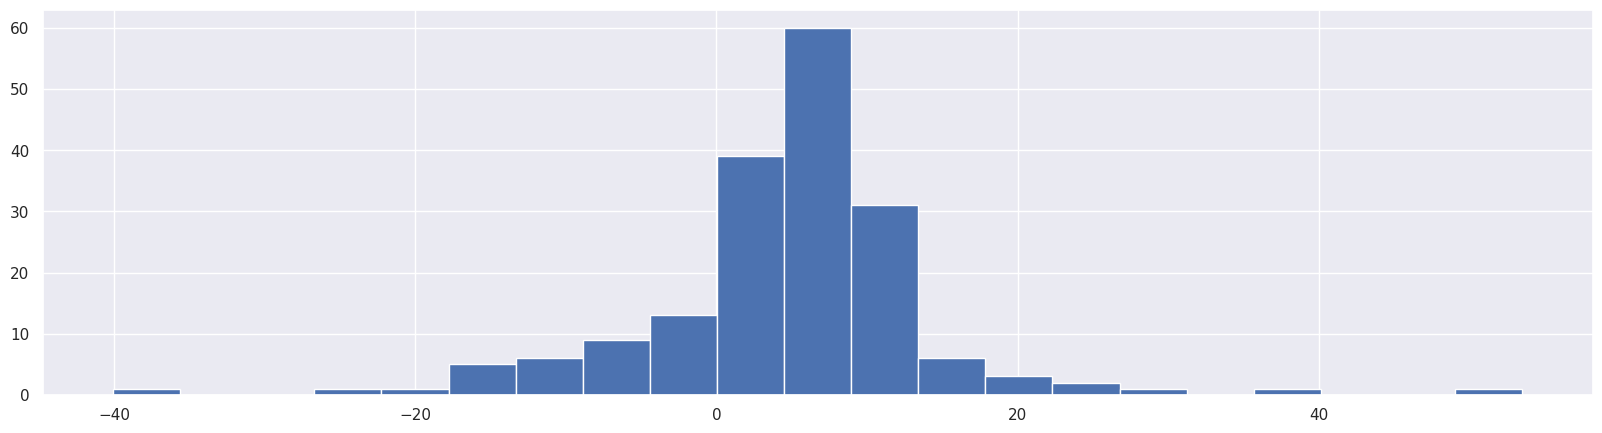

In [36]:
slippage = exec_df[["twap_mid_price", "exec_sell_price", "exec_buy_price"]]

slippage["sell_slippage_bps"] = (
    (exec_df["exec_sell_price"] - exec_df["twap_mid_price"])
    / exec_df["twap_mid_price"]
    * 1e4
)

# slippage = df["twap_mid_price"] /

slippage["sell_slippage_bps"].hist(bins=21)

print("sell_slippage_bps.mean=", slippage["sell_slippage_bps"].mean())
print("sell_slippage_bps.median=", slippage["sell_slippage_bps"].median())

### Commentary

The quick look into the rate of successful trades indicated that for the given asset (`ADA/USDT`) and the date the successful "buy" order can be met for 16% of the time and a "sell" order is not met at all.

# Generate limit order prices and simulate

In [37]:
df_flat.head()

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00


In [38]:
bid_col = "bid_price"
ask_col = "ask_price"
# Price buy limit order with respect to the bid.
buy_reference_price_col = "bid_price"
# Price sell limit order with respect to the ask.
sell_reference_price_col = "ask_price"
# Price orders halfway between near side and midpoint.
buy_spread_frac_offset = 0.25
sell_spread_frac_offset = -0.25
# Reprice orders every minute.
subsample_freq = "1T"
freq_offset = "0T"
# Keep orders in force for one minute.
ffill_limit = 60
tick_decimals = 5
# Generate limit order prices.
limit_orders = cofinanc.generate_limit_order_price(
    df_flat,
    bid_col,
    ask_col,
    buy_reference_price_col,
    sell_reference_price_col,
    buy_spread_frac_offset,
    sell_spread_frac_offset,
    subsample_freq,
    freq_offset,
    ffill_limit,
    tick_decimals,
)

In [39]:
limit_orders.head()

,buy_limit_order_price,sell_limit_order_price,buy_order_num,sell_order_num
end_ts,,,,
2022-12-13 19:00:00-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:01-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:03-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:04-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:05-05:00,0.31402,0.31408,1.0,1.0


<AxesSubplot: xlabel='end_ts'>

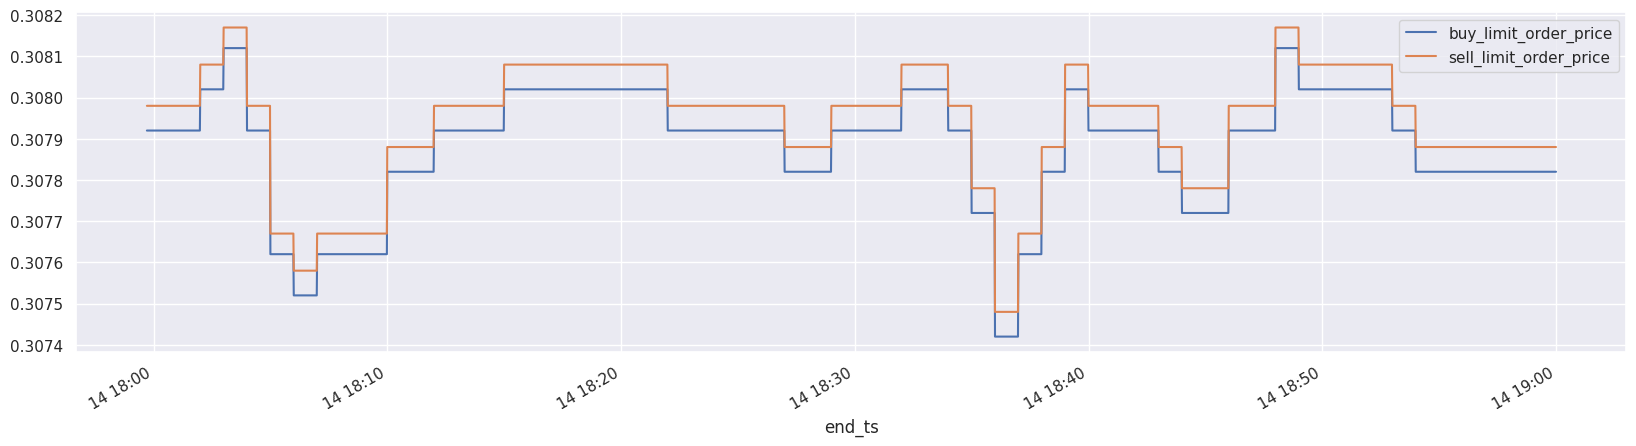

In [40]:
limit_orders[["buy_limit_order_price", "sell_limit_order_price"]].tail(60 * 60).plot()

In [41]:
df_flat_with_limit_orders = pd.concat([df_flat, limit_orders], axis=1)
df_flat_with_limit_orders.head()

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts,buy_limit_order_price,sell_limit_order_price,buy_order_num,sell_order_num
end_ts,,,,,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00,0.31402,0.31408,1.0,1.0
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00,0.31402,0.31408,1.0,1.0


<AxesSubplot: xlabel='end_ts'>

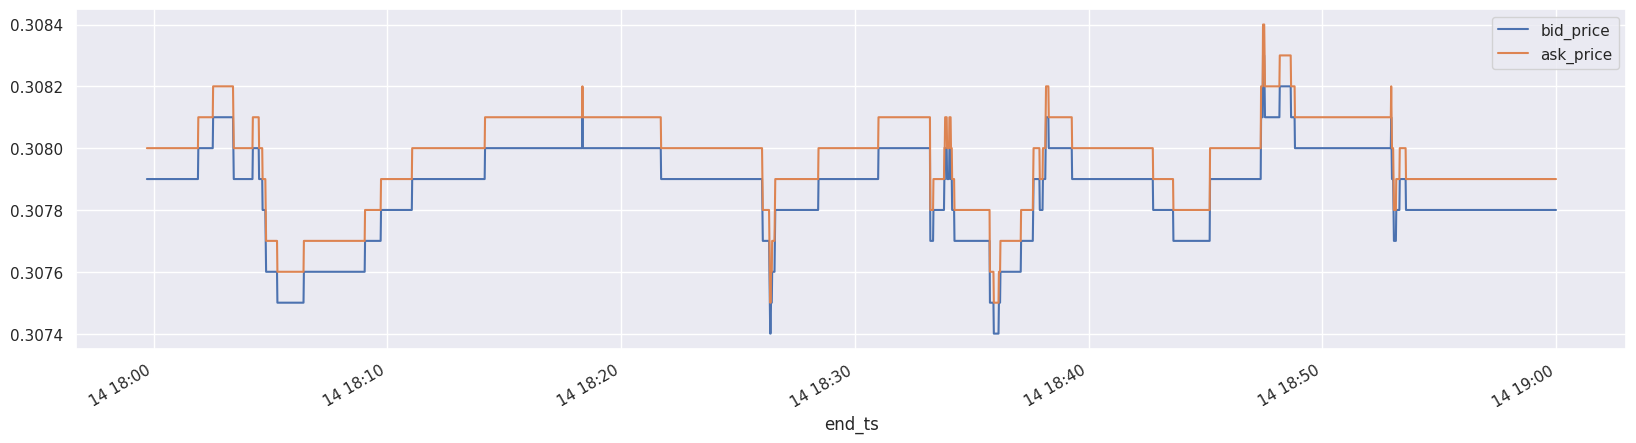

In [42]:
df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60).plot()

In [43]:
executions = cofinanc.estimate_limit_order_execution(
    df_flat_with_limit_orders,
    bid_col,
    ask_col,
    "buy_limit_order_price",
    "sell_limit_order_price",
    "buy_order_num",
    "sell_order_num",
)

In [44]:
executions.head()

,limit_buy_executed,limit_sell_executed,buy_trade_price,sell_trade_price
end_ts,,,,
2022-12-13 19:00:00-05:00,False,False,NaN,NaN
2022-12-13 19:00:01-05:00,False,False,NaN,NaN
2022-12-13 19:00:03-05:00,False,False,NaN,NaN
2022-12-13 19:00:04-05:00,False,False,NaN,NaN
2022-12-13 19:00:05-05:00,True,False,0.31402,NaN


In [45]:
df_flat.head()

,ask_price,ask_size,bid_price,bid_size,full_symbol,knowledge_timestamp,start_ts
end_ts,,,,,,,
2022-12-13 19:00:00-05:00,0.3141,171302.0,0.3140,82466.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:00-05:00
2022-12-13 19:00:01-05:00,0.3141,171302.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:01-05:00
2022-12-13 19:00:03-05:00,0.3141,171277.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:03-05:00
2022-12-13 19:00:04-05:00,0.3141,171294.0,0.3140,82188.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:04-05:00
2022-12-13 19:00:05-05:00,0.3140,40392.0,0.3139,85929.0,binance::ADA_USDT,2022-12-15 11:01:35.784679+00:00,2022-12-13 18:59:05-05:00


In [46]:
limit_order_and_execution_df = (
    cofinanc.generate_limit_orders_and_estimate_execution(
        df_flat,
        bid_col,
        ask_col,
        buy_reference_price_col,
        sell_reference_price_col,
        buy_spread_frac_offset,
        sell_spread_frac_offset,
        subsample_freq,
        freq_offset,
        ffill_limit,
        tick_decimals,
    )
)

In [47]:
limit_order_and_execution_df.head()

,buy_limit_order_price,sell_limit_order_price,buy_order_num,sell_order_num,limit_buy_executed,limit_sell_executed,buy_trade_price,sell_trade_price
end_ts,,,,,,,,
2022-12-13 19:00:00-05:00,0.31402,0.31408,1.0,1.0,False,False,NaN,NaN
2022-12-13 19:00:01-05:00,0.31402,0.31408,1.0,1.0,False,False,NaN,NaN
2022-12-13 19:00:03-05:00,0.31402,0.31408,1.0,1.0,False,False,NaN,NaN
2022-12-13 19:00:04-05:00,0.31402,0.31408,1.0,1.0,False,False,NaN,NaN
2022-12-13 19:00:05-05:00,0.31402,0.31408,1.0,1.0,True,False,0.31402,NaN


In [48]:
# Average prices over 5-minute bars.
# The previously boolean columns "limit_buy_executed" and "limit_sell_executed" represent
#  percentage of the time an execution was possible during the bar.
bar_executions = limit_order_and_execution_df.resample(
    "5T", closed="right", label="right"
).mean()
bar_executions.head()

,buy_limit_order_price,sell_limit_order_price,buy_order_num,sell_order_num,limit_buy_executed,limit_sell_executed,buy_trade_price,sell_trade_price
end_ts,,,,,,,,
2022-12-13 19:00:00-05:00,0.314020,0.314080,1.000000,1.000000,0.000000,0.000000,NaN,NaN
2022-12-13 19:05:00-05:00,0.314329,0.314385,3.030201,3.030201,0.010067,0.013423,0.314423,0.314455
2022-12-13 19:10:00-05:00,0.314601,0.314659,8.016667,8.016667,0.006667,0.010000,0.314770,0.314547
2022-12-13 19:15:00-05:00,0.314544,0.314602,13.020067,13.020067,0.006689,0.013378,0.314570,0.314630
2022-12-13 19:20:00-05:00,0.314918,0.314976,18.020067,18.020067,0.013378,0.006689,0.314872,0.315030


In [49]:
execution_summary_df = pd.concat(
    [limit_order_and_execution_df, df_flat[bid_col], df_flat[ask_col]], axis=1
)

In [50]:
buy_trade_price_col = "buy_trade_price"
sell_trade_price_col = "sell_trade_price"
execution_quality_df = cofinanc.compute_bid_ask_execution_quality(
    execution_summary_df.resample("5T", label="right", closed="right").mean(),
    bid_col,
    ask_col,
    buy_trade_price_col,
    sell_trade_price_col,
)

array([[<AxesSubplot: title={'center': 'sell_trade_midpoint_slippage_bps'}>,
        <AxesSubplot: title={'center': 'buy_trade_midpoint_slippage_bps'}>]],
      dtype=object)

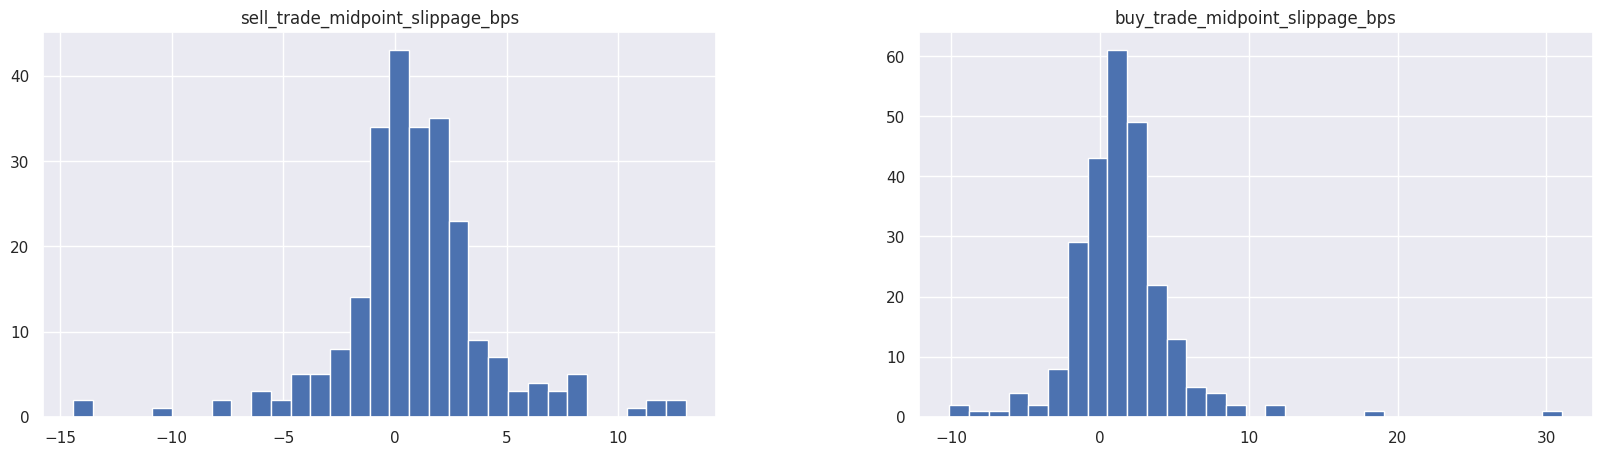

In [51]:
execution_quality_df[
    [
        "sell_trade_midpoint_slippage_bps",
        "buy_trade_midpoint_slippage_bps",
    ]
].hist(bins=31)

In [52]:
execution_quality_df.apply(costatis.compute_moments)

,bid_ask_midpoint,spread_notional,spread_bps,buy_trade_price_improvement_notional,buy_trade_price_improvement_bps,buy_trade_price_improvement_spread_pct,sell_trade_price_improvement_notional,sell_trade_price_improvement_bps,sell_trade_price_improvement_spread_pct,buy_trade_midpoint_slippage_notional,buy_trade_midpoint_slippage_bps,sell_trade_midpoint_slippage_notional,sell_trade_midpoint_slippage_bps
mean,0.310935,0.000100,3.220660,0.000005,0.153680,5.474133,0.000021,0.688461,21.726308,0.000045,1.456953,0.000029,0.922770
std,0.002230,0.000002,0.054999,0.000111,3.571677,105.543039,0.000107,3.451261,106.160953,0.000111,3.584976,0.000107,3.457270
skew,-0.194347,13.516983,10.153745,-2.524529,-2.536062,-1.761232,0.155580,0.146536,0.227743,2.582835,2.596866,-0.140248,-0.128026
kurtosis,-0.938323,190.551560,131.354605,19.124038,19.254920,11.576601,4.081068,4.123922,3.996111,19.749253,19.890090,4.107930,4.152455


In [53]:
bid_ask_midpoint = (0.5 * (df_flat["ask_price"] + df_flat["bid_price"])).rename(
    "bid_ask_midpoint"
)
bar_bid_ask_midpoint = bid_ask_midpoint.resample(
    "5T", closed="right", label="right"
).mean()
bar_executions_with_midpoint = pd.concat(
    [
        bar_executions[["buy_trade_price", "sell_trade_price"]],
        bar_bid_ask_midpoint,
    ],
    axis=1,
)

<AxesSubplot: xlabel='end_ts'>

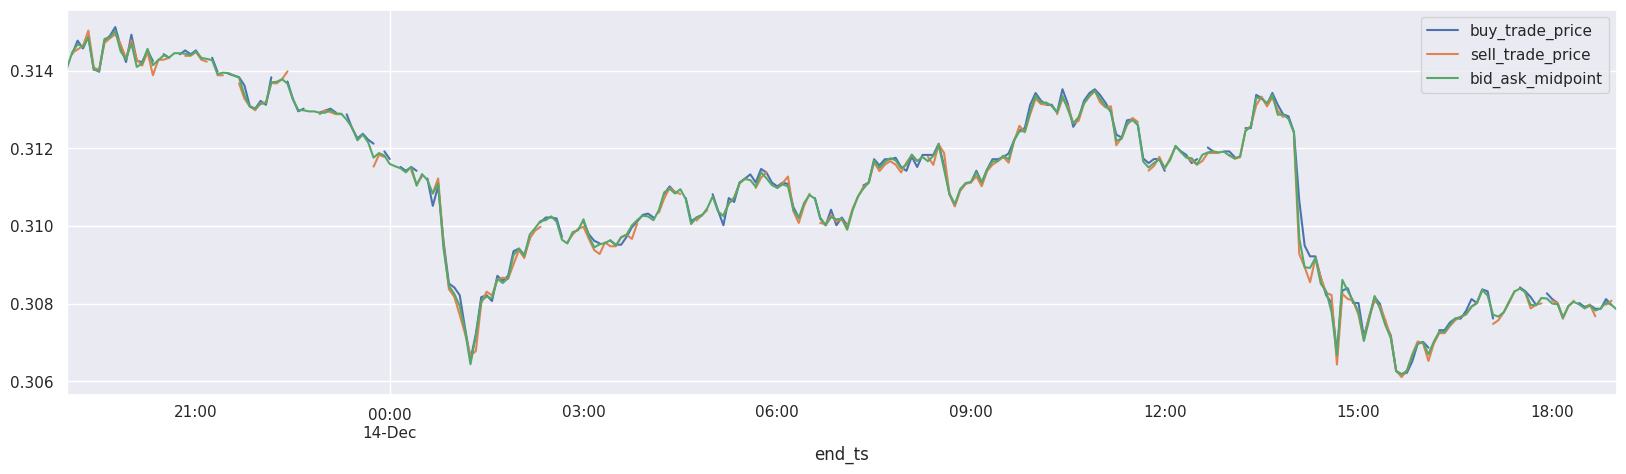

In [54]:
bar_executions_with_midpoint.plot()

In [55]:
# We may also use cofinanc.apply_execution_prices_to_trades()
#  to assign prices to a single column of buys/sells

# Compare with trade data

In [56]:
import helpers.hdatetime as hdateti
import helpers.hparquet as hparquet

In [57]:
first_timestamp = pd.Timestamp("2022-12-14 17:59:43-05:00")
last_timestamp = pd.Timestamp("2022-12-14 19:00:00-05:00")

In [58]:
start = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp(first_timestamp), unit="s"
)
end = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp(last_timestamp), unit="s"
)
# Define filters for data period.
# Note(Juraj): it's better from Airflow execution perspective
#  to keep the interval closed: [start, end].
filters = [
    ("timestamp", ">=", start),
    ("timestamp", "<=", end),
    ("currency_pair", "==", "ADA_USDT"),
    # ("level", "==", 1)
]
file_name = "s3://cryptokaizen-data/v3/periodic_daily/airflow/downloaded_1sec/parquet/trades/futures/v3_1/crypto_chassis/binance/v1_0_0/"
df = hparquet.from_parquet(file_name, filters=filters, aws_profile="ck")

In [59]:
df.head()

,timestamp,price,size,is_buyer_maker,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,
2022-12-14 22:59:43+00:00,1671058783,0.308,1.0,0,binance,2022-12-23 15:56:21.850675+00:00,ADA_USDT,2022,12
2022-12-14 22:59:43+00:00,1671058783,0.308,516.0,0,binance,2022-12-23 15:56:21.850675+00:00,ADA_USDT,2022,12
2022-12-14 22:59:44+00:00,1671058784,0.308,140.0,0,binance,2022-12-23 15:56:21.850675+00:00,ADA_USDT,2022,12
2022-12-14 22:59:47+00:00,1671058787,0.308,72.0,0,binance,2022-12-23 15:56:21.850675+00:00,ADA_USDT,2022,12
2022-12-14 22:59:48+00:00,1671058788,0.308,797.0,0,binance,2022-12-23 15:56:21.850675+00:00,ADA_USDT,2022,12


<AxesSubplot: xlabel='timestamp'>

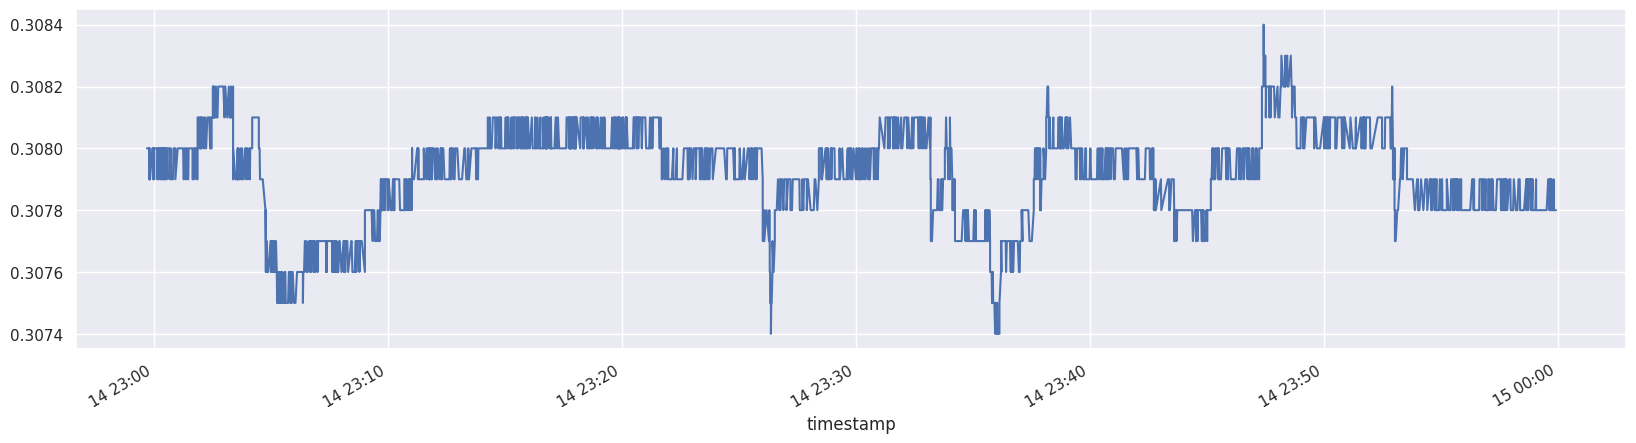

In [60]:
df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["price"].plot()

<AxesSubplot: xlabel='timestamp'>

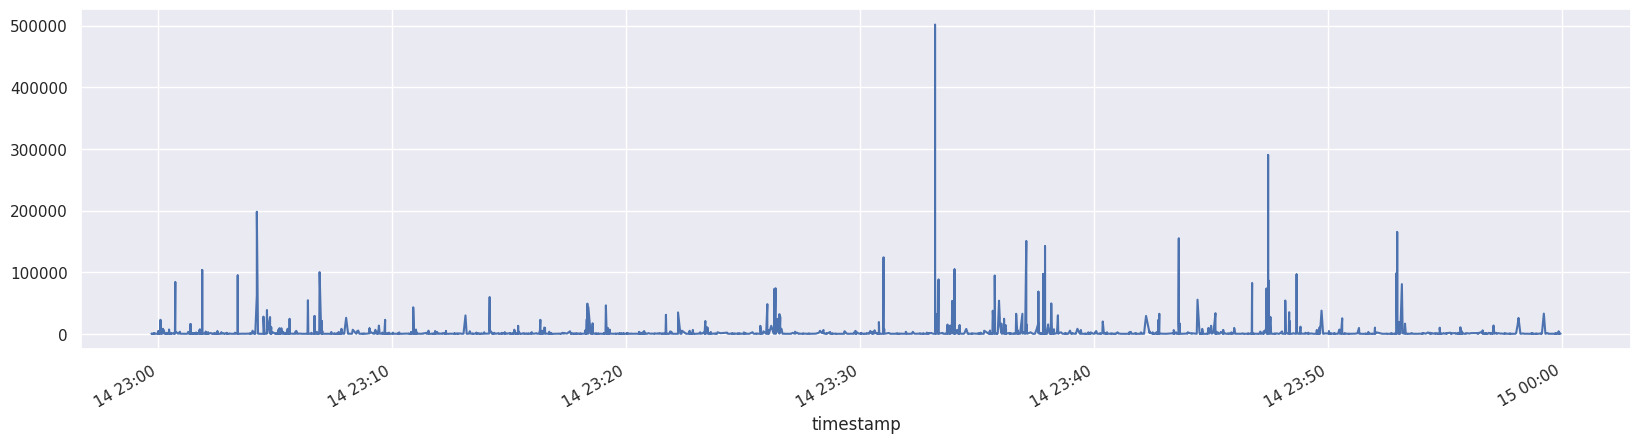

In [61]:
df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["size"].plot()

<AxesSubplot: xlabel='end_ts'>

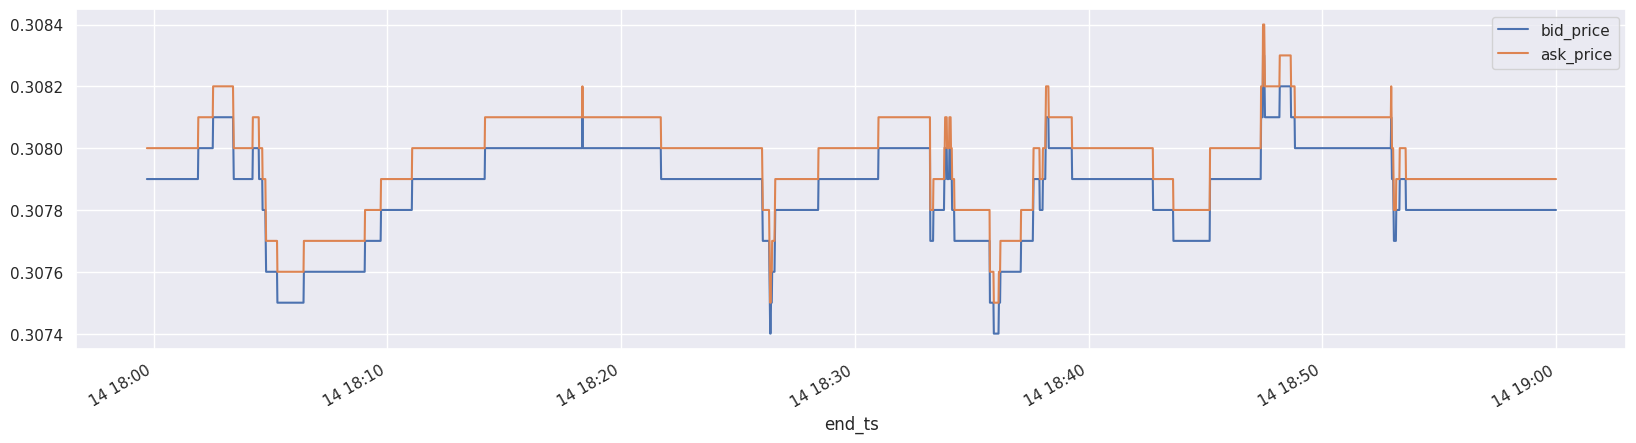

In [62]:
df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60).plot()

In [63]:
size = df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["size"]
bid_ask = df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60)
bid_ask.index = bid_ask.index.tz_convert("UTC")

<AxesSubplot: xlabel='end_ts'>

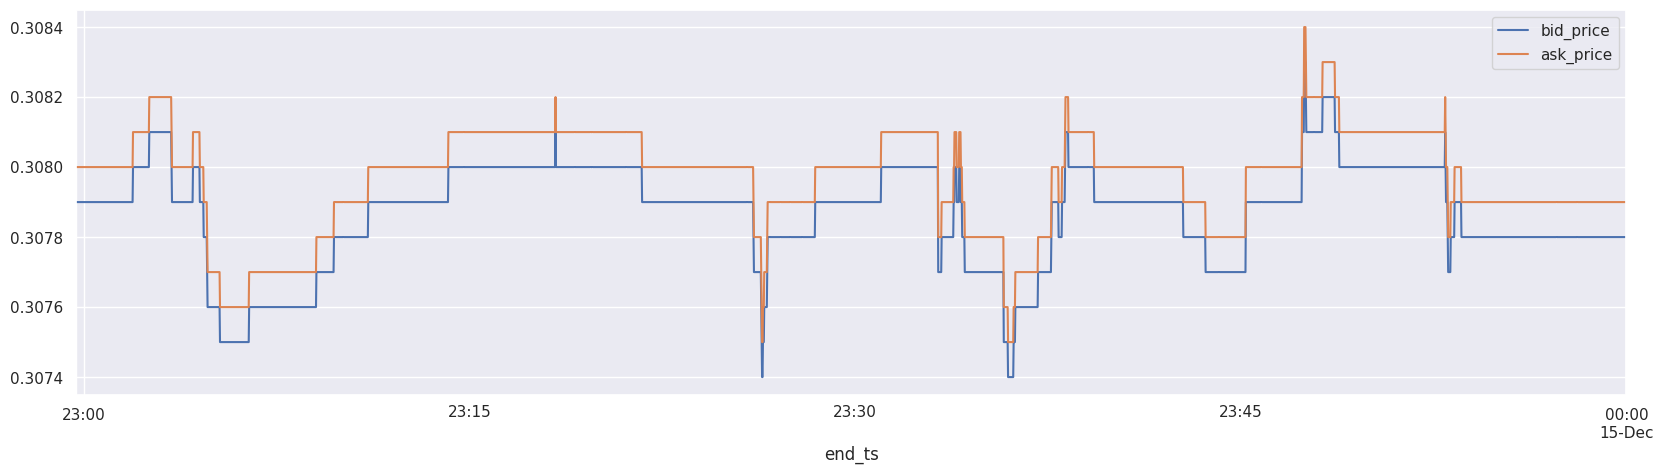

In [64]:
bid_ask.resample("1s", label="right", closed="right").sum(min_count=1).plot()

<AxesSubplot: xlabel='timestamp'>

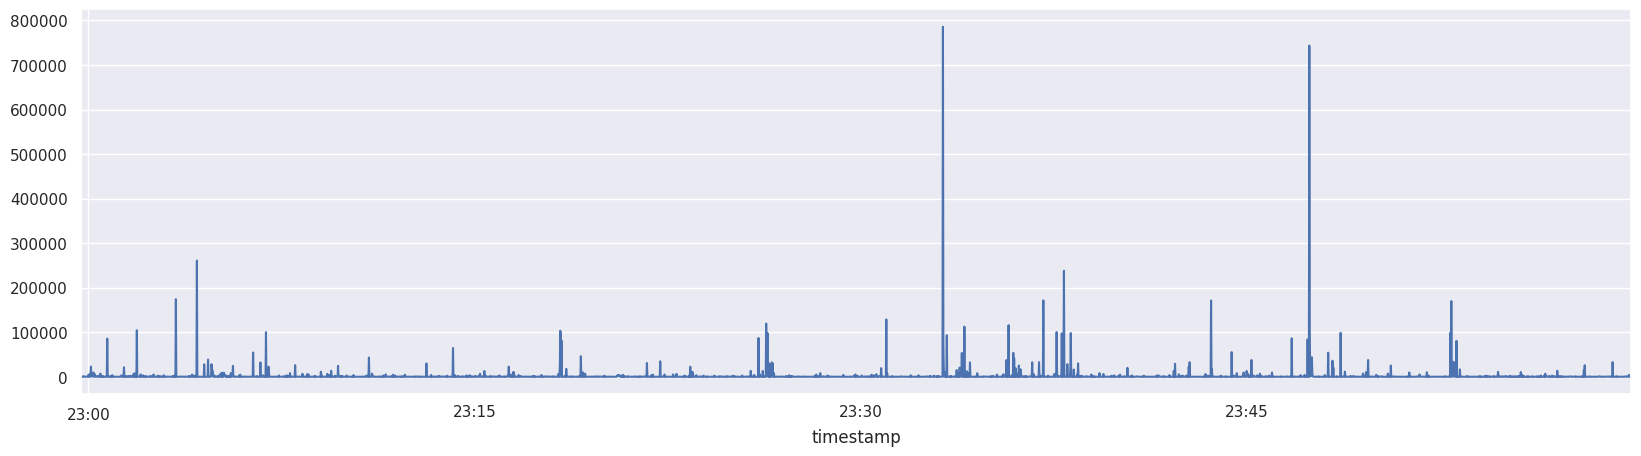

In [65]:
size.resample("1s", label="right", closed="right").sum().plot()